In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.signal import welch

In [24]:
# Rectangular PSD
def Gr(f,f1,p1,f2,p2,A1,A2):
    out = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] >= f1 and f[i] <= p1:
            out[i] = A1
        elif f[i] >= f2 and f[i] <= p2:
            out[i] = A2;
    return out;

In [25]:
# Smooth PSD
def Gs(f,A1,f1,Q1,A2,f2,Q2,fc):
    out1 = np.zeros(len(f)); out2 = np.zeros(len(f));
    for i in range(len(f)):
        if f[i] <= fc:
            out1[i] = A1/np.sqrt(1+((f1-f[i])**2)/(Q1**2));
            out2[i] = A2/np.sqrt(1+((f2-f[i])**2)/(Q2**2));
        else:
            out1[i] = 0;
            out2[i] = 0;
    out = out1 + out2;
    return out

**참고**

Nt, fs, tmax를 아는경우,

dt = 1/fs

Nf = Nt/2

fmax = fs/2

<공식>

Nt * df * dt = 1

In [26]:
# Given PSD
Nt = 2**10; Nf = int(Nt/2);
# Fig 3.7.(a) SP-17 TH
def G1(f):
    A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
    return Gr(f,f1,p1,f2,p2,A1,A2);
def G2(f):
    A1 = 4000; f1 = 2; p1 = 17; A2 = 30801; f2 = 101; p2 = 117; xm = 0.981; r = 0.988;
    return Gr(f,f1,p1,f2,p2,A1,A2);
def G3(f):
    A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
    return Gs(f,A1,f1,Q1,A2,f2,Q2,fc);

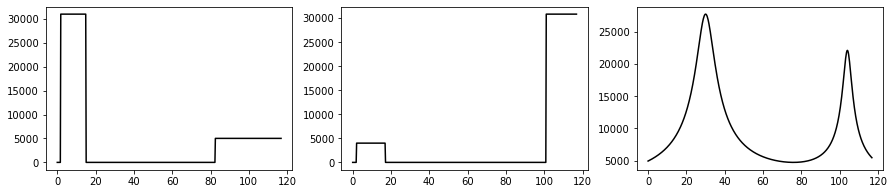

In [27]:
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
freq = np.arange(Nf)*df; g1 = G1(freq);
A1 = 4000; f1 = 2; p1 = 17; A2 = 30801; f2 = 101; p2 = 117; xm = 0.981; r = 0.988;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
freq = np.arange(Nf)*df; g2 = G2(freq);
A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
freq = np.arange(Nf)*df; g3 = G3(freq);
plt.figure(figsize=(15,3));
plt.subplot(131); plt.plot(freq,g1,'k-');
plt.subplot(132); plt.plot(freq,g2,'k-');
plt.subplot(133); plt.plot(freq,g3,'k-');

In [28]:
# Sinusoidal Method
time = np.arange(Nt)*dt; th1 = np.zeros(Nt);
A = np.zeros(Nf);
for j in range(1,Nf):
    A[j] = np.sqrt(2)*np.sqrt(df*(g1[j-1]+g1[j])/2);
for i in range(Nt):
    for j in range(Nf):
        th1[i] += A[j]*np.sin(2*np.pi*freq[j]*time[i]+np.random.uniform(low=-np.pi,high=np.pi));

A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)

th1 *= grms1_spec/grms1_syn;        
        
# mean removal
th1 -= np.mean(th1);

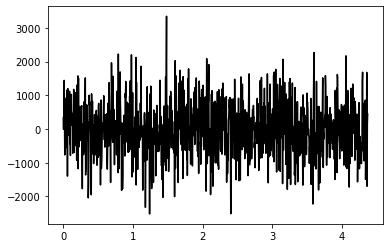

In [29]:
plt.plot(time,th1,'k-');

In [30]:
# GRMS Check
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)
print("spec grms = %.2f  syn grms = %.2f"%(grms1_spec,grms1_syn));
print("mean = %.2f"%(np.mean(th1)));

spec grms = 812.88  syn grms = 812.88
mean = 0.00


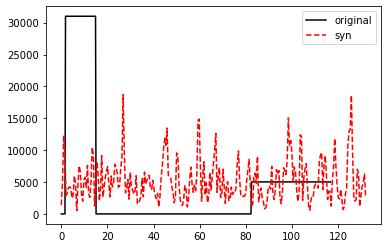

In [31]:
# PSD Check
freq1_syn,psd1_syn = welch(th1,fs = fs,nperseg=Nf);
plt.plot(freq,g1,'k-',label='original');
plt.plot(freq1_syn,psd1_syn,'r--',label='syn'); plt.legend(loc='upper right');

In [67]:
# White Noise Method
time = np.arange(Nt)*dt; th1 = np.random.uniform(size=Nt);
ft_th1 = np.fft.fft(th1);
ft_th1[:Nf] *= np.sqrt(g1*df);
ft_th1[Nf:] = np.conjugate(np.flip(ft_th1[:Nf]));
ft_th1[Nf-1] = 0;
ft_th1[Nf] = 0;
th1 = np.fft.ifft(ft_th1);
th1 = th1.real;

A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)

th1 *= grms1_spec/grms1_syn;

In [68]:
ft_th1 = np.fft.fft(th1);
ft_th1[:Nf] *= np.sqrt(g1);
ft_th1[Nf:] = np.conjugate(np.flip(ft_th1[:Nf]));
ft_th1[Nf] = 0;
th1 = np.fft.ifft(ft_th1);
th1 = th1.real;

A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)

th1 *= grms1_spec/grms1_syn;

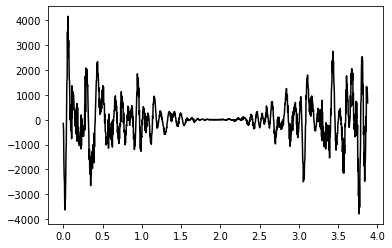

In [69]:
plt.plot(time,th1,'k-');

In [70]:
# GRMS Check
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)
print("spec grms = %.2f  syn grms = %.2f"%(grms1_spec,grms1_syn));
print("mean = %.2f"%(np.mean(th1)));

spec grms = 812.88  syn grms = 812.88
mean = 0.00


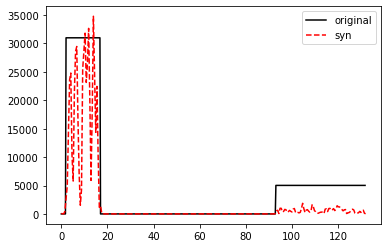

In [71]:
# PSD Check
freq1_syn,psd1_syn = welch(th1,fs = fs,nperseg=Nf);
plt.plot(freq,g1,'k-',label='original');
plt.plot(freq1_syn,psd1_syn,'r--',label='syn'); plt.legend(loc='upper right');

In [72]:
# IFFT Method
g11 = np.zeros(Nt,'complex');
phi = np.random.uniform(low=-np.pi,high=np.pi,size=Nf);
g11[:Nf] = np.sqrt(g1)*np.exp(1j*phi);
g11[Nf:] = np.conjugate(np.flip(g11[:Nf]));
g31[Nf-1] = 0;
g31[Nf] = 0;
th1 = np.fft.fft(g11);
th1 = th1.real

A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)

th1 *= grms1_spec/grms1_syn;

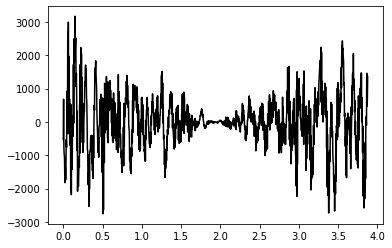

In [73]:
plt.plot(time,th1,'k-');

In [74]:
# GRMS Check
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms1_spec = np.sqrt(A1*(p1-f1)+A2*(p2-f2))
grms1_syn = np.std(th1)
print("spec grms = %.2f  syn grms = %.2f"%(grms1_spec,grms1_syn));
print("mean = %.2f"%(np.mean(th1)));

spec grms = 812.88  syn grms = 812.88
mean = 0.00


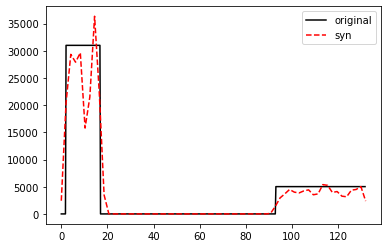

In [75]:
# PSD Check
freq1_syn,psd1_syn = welch(th1,fs = fs,nperseg=2**7);
plt.plot(freq,g1,'k-',label='original');
plt.plot(freq1_syn,psd1_syn,'r--',label='syn'); plt.legend(loc='upper right');

In [76]:
# IFFT Method
g31 = np.zeros(Nt,'complex');
phi = np.random.uniform(low=-np.pi,high=np.pi,size=Nf);
g31[:Nf] = np.sqrt(g3)*np.exp(1j*phi);
g31[Nf:] = np.flip(g31[:Nf]);
g31[Nf-1] = 0;
g31[Nf] = 0;
th3 = np.fft.fft(g31);
th3 = th3.real


A1 = 27019; f1 = 30; Q1 = 5; A2=20264; f2=104; Q2=2.5; fc = 231; xm=0.493; r=0.600;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
freq = np.arange(Nf)*df; g3 = G3(freq);
grms3_spec = np.sqrt(np.trapz(g3,freq));
grms3_syn = np.std(th3)

th3 *= grms3_spec/grms3_syn;

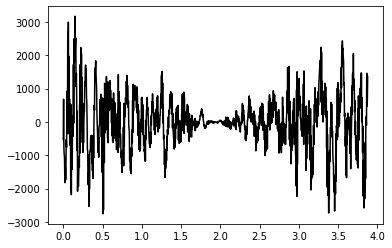

In [77]:
plt.plot(time,th1,'k-');

In [78]:
# GRMS Check
A1 = 31000; f1 = 2; p1 = 17; A2 = 5020; f2 = 93; p2 = 132; xm = 0.137; r = 0.270;
Nt = 1024; Nf = 512; fmax = p2; fs = 2*fmax; dt = 1/fs; tmax = dt*Nt; df = 1/(Nt*dt); fmax = fs/2;
grms3_spec = np.sqrt(np.trapz(g3,freq));
grms3_syn = np.std(th3)
print("spec grms = %.2f  syn grms = %.2f"%(grms3_spec,grms3_syn));
print("mean = %.2f"%(np.mean(th1)));

spec grms = 1103.86  syn grms = 1103.86
mean = 0.00


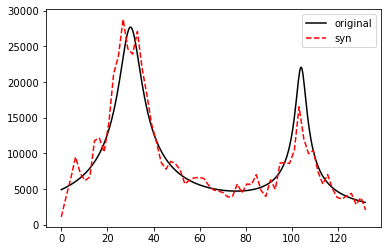

In [79]:
# PSD Check
freq3_syn,psd3_syn = welch(th3,fs = fs,nperseg=2**7);
plt.plot(freq,g3,'k-',label='original');
plt.plot(freq3_syn,psd3_syn,'r--',label='syn'); plt.legend(loc='upper right');